In [1]:
!python --version

Python 3.7.13


**Julien VALENTIN**, **mars 2022**, d'après 

> [Machine learning in Python with scikit-learn](https://www.fun-mooc.fr/fr/cours/machine-learning-python-scikit-learn/) d'I.N.R.I.A sur [F.U.N](https://www.fun-mooc.fr/fr/)

### Import

In [2]:
!rm adult-census.csv
!wget https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/57f2e69a976136a9d1f9409b69ef0d6b3509903c/datasets/adult-census.csv

--2022-03-28 16:21:14--  https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/57f2e69a976136a9d1f9409b69ef0d6b3509903c/datasets/adult-census.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5383740 (5.1M) [text/plain]
Saving to: ‘adult-census.csv’

adult-census.csv    100%[===================>]   5.13M  --.-KB/s    in 0.09s   

2022-03-28 16:21:14 (54.4 MB/s) - ‘adult-census.csv’ saved [5383740/5383740]



In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split

adult_census = pd.read_csv("adult-census.csv")

target_name = "class"
target = adult_census[target_name]
data = adult_census.drop(columns=[target_name, "education-num"])

data_train, data_test, target_train, target_test = train_test_split(
    data, target, train_size=0.2, random_state=42)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   marital-status  48842 non-null  object
 4   occupation      48842 non-null  object
 5   relationship    48842 non-null  object
 6   race            48842 non-null  object
 7   sex             48842 non-null  object
 8   capital-gain    48842 non-null  int64 
 9   capital-loss    48842 non-null  int64 
 10  hours-per-week  48842 non-null  int64 
 11  native-country  48842 non-null  object
dtypes: int64(4), object(8)
memory usage: 4.5+ MB


### Modélisation par HistGradientBoostingClassifier

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer(
    [('cat_preprocessor', categorical_preprocessor,
      selector(dtype_include=object))],
    remainder='passthrough', sparse_threshold=0)

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=42))
])

### Etude des paramètres `learning_rate` et `max_leaf_nodes`

In [5]:
from sklearn.model_selection import cross_val_score

learning_rate = [0.01, 0.1, 1, 10]
max_leaf_nodes = [3, 10, 30]

best_score = 0
best_params = {}
for lr in learning_rate:
    for mln in max_leaf_nodes:
        print(f"Evaluating model with learning rate {lr:.3f}"
              f" and max leaf nodes {mln}... ", end="")
        model.set_params(
            classifier__learning_rate=lr,
            classifier__max_leaf_nodes=mln
        )
        scores = cross_val_score(model, data_train, target_train, cv=2)
        mean_score = scores.mean()
        print(f"score: {mean_score:.3f}")
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'learning-rate': lr, 'max leaf nodes': mln}
            print(f"Found new best model with score {best_score:.3f}!")
        print(80*"-")

print(f"The best accuracy obtained is {best_score:.3f}")
print(f"The best parameters found are:\n {best_params}")

Evaluating model with learning rate 0.010 and max leaf nodes 3... score: 0.789
Found new best model with score 0.789!
--------------------------------------------------------------------------------
Evaluating model with learning rate 0.010 and max leaf nodes 10... score: 0.813
Found new best model with score 0.813!
--------------------------------------------------------------------------------
Evaluating model with learning rate 0.010 and max leaf nodes 30... score: 0.842
Found new best model with score 0.842!
--------------------------------------------------------------------------------
Evaluating model with learning rate 0.100 and max leaf nodes 3... score: 0.847
Found new best model with score 0.847!
--------------------------------------------------------------------------------
Evaluating model with learning rate 0.100 and max leaf nodes 10... score: 0.859
Found new best model with score 0.859!
--------------------------------------------------------------------------------
Ev

### Avec les paramètres optimaux

In [6]:
best_lr = best_params['learning-rate']
best_mln = best_params['max leaf nodes']

model.set_params(classifier__learning_rate=best_lr,
                 classifier__max_leaf_nodes=best_mln)
model.fit(data_train, target_train)
test_score = model.score(data_test, target_test)

print(f"Test score after the parameter tuning: {test_score:.3f}")

Test score after the parameter tuning: 0.870


### Automatisation avec `GridSearch`

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30)}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=2)

model_grid_search.fit(data_train, target_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f22bdeab990>)])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=10,
                                                                       random_state=42))]),
             n_jobs=2,
             param_

In [8]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 10}


In [9]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
4,0.462287,0.035267,0.192665,0.006520,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.861794,0.856880,0.859337,0.002457,1
5,1.181474,0.146980,0.257934,0.024241,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.859337,0.855651,0.857494,0.001843,2
6,0.372674,0.004997,0.178057,0.018351,1,3,"{'classifier__learning_rate': 1, 'classifier__...",0.851351,0.853194,0.852273,0.000921,3
3,0.347575,0.075638,0.184907,0.014491,0.1,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.849918,0.844185,0.847052,0.002867,4
2,1.061959,0.253116,0.168340,0.045098,0.01,30,"{'classifier__learning_rate': 0.01, 'classifie...",0.845823,0.837633,0.841728,0.004095,5


In [10]:
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
4,0.1,10,0.859337,0.002457,1
5,0.1,30,0.857494,0.001843,2
6,1,3,0.852273,0.000921,3
3,0.1,3,0.847052,0.002867,4
2,0.01,30,0.841728,0.004095,5
7,1,10,0.832719,0.001024,6
8,1,30,0.827907,0.000307,7
1,0.01,10,0.813473,0.001433,8
0,0.01,3,0.789210,0.001126,9
11,10,30,0.638514,0.082002,10


In [11]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.789210,0.813473,0.841728
0.10,0.847052,0.859337,0.857494
1.00,0.852273,0.832719,0.827907
10.00,0.288288,0.479934,0.638514


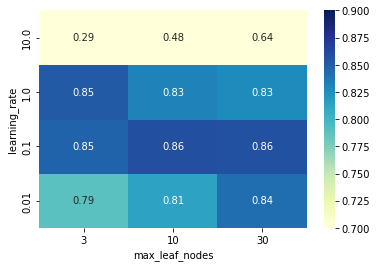

In [12]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()